# 1. 5개의 질병에 대해 각각의 모델 생성
# 2. 앙상블 기법을 통해 합쳐 최종 결과 생성
- bagging 방식 사용
- ulcer : 각막궤양
- fseques : 각막부골편
- conjunc : 결막염
- nonulcer: 비궤양성각막염
- bleph : 안검염

In [1]:
# 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,606 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and dire

In [1]:
# 필요 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import pickle
import random

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
# 모델 생성
def make_model(input_shpae):
    base_model = ResNet50(weights='imagenet',input_shape=input_shape,include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
# num_classes = 2

# 각막궤양 모델
model_ulcer = make_model(input_shape)

# 각막부골편 모델
model_fseques = make_model(input_shape)

# 결막염 모델
model_conjunc = make_model(input_shape)

# 비궤양성각막염 모델
model_nonulcer = make_model(input_shape)

# 안검염 모델
model_bleph = make_model(input_shape)

# 모델 예시 확인
model_conjunc.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 클래스 이름 리스트
classes = ['각막궤양', '각막부골편', '결막염', '비궤양성각막염', '안검염']

# 기본 경로 설정
train_base_path = '/content/drive/MyDrive/종합설계/Train/안구/일반/'
valid_base_path = '/content/drive/MyDrive/종합설계/Valid/안구/일반/'

# ImageDataGenerator 설정
train_gen = ImageDataGenerator(rescale=1/255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

valid_gen = ImageDataGenerator(rescale=1/255)

# 데이터 제너레이터를 저장할 딕셔너리 초기화
train_generators = {}
valid_generators = {}

# 각 클래스에 대해 제너레이터 생성
for class_name in classes:
    train_path = f"{train_base_path}{class_name}/"
    valid_path = f"{valid_base_path}{class_name}/"

    train_generators[class_name] = train_gen.flow_from_directory(directory=train_path,
                                                                 target_size=(224, 224),
                                                                 batch_size=32,
                                                                 class_mode='binary',
                                                                 shuffle=True)

    valid_generators[class_name] = valid_gen.flow_from_directory(directory=valid_path,
                                                                 target_size=(224, 224),
                                                                 batch_size=32,
                                                                 class_mode='binary',
                                                                 shuffle=False)

Found 6245 images belonging to 2 classes.
Found 796 images belonging to 2 classes.
Found 6234 images belonging to 2 classes.
Found 787 images belonging to 2 classes.
Found 6239 images belonging to 2 classes.
Found 783 images belonging to 2 classes.
Found 2391 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 1910 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [5]:
# 모델 학습
models = {'각막궤양' : model_ulcer,
          '각막부골편' : model_fseques,
          '결막염' : model_conjunc,
          '비궤양성각막염' : model_nonulcer,
          '안검염' : model_bleph}

batch_size = 64
epochs = 100
all_history = {}

for class_name, model in models.items():
    print(f"{class_name} 모델 학습 시작")

    checkpoint = ModelCheckpoint(f"best_model_{class_name}.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='max')

    history = model.fit(train_generators[class_name],
                        steps_per_epoch=train_generators[class_name].samples // batch_size,
                        validation_data=valid_generators[class_name],
                        validation_steps=valid_generators[class_name].samples // batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=[checkpoint, early_stopping])

    all_history[class_name] = history.history
    with open(f'history_{class_name}.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    print(f"{class_name} 모델 학습 완료.")

각막궤양 모델 학습 시작
Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.7890 
Epoch 1: val_loss improved from inf to 1.06154, saving model to best_model_각막궤양.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 1538s 15s/step - loss: 0.4461 - accuracy: 0.7890 - val_loss: 1.0615 - val_accuracy: 0.0000e+00
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8876
Epoch 2: val_loss did not improve from 1.06154
97/97 [==============================] - 690s 7s/step - loss: 0.2892 - accuracy: 0.8876 - val_loss: 1.2677 - val_accuracy: 0.0000e+00
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9169
Epoch 3: val_loss did not improve from 1.06154
97/97 [==============================] - 380s 4s/step - loss: 0.2224 - accuracy: 0.9169 - val_loss: 1.2217 - val_accuracy: 0.0000e+00
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9127
Epoch 4: val_loss did not improve from 1.06154
97/97 [==============================] - 208s 2s/step - loss: 0.2203 - accuracy: 0.9127 - val_loss: 1.3377 - val_accuracy: 0.0026
Epoch 5/100
97/97 [=====================

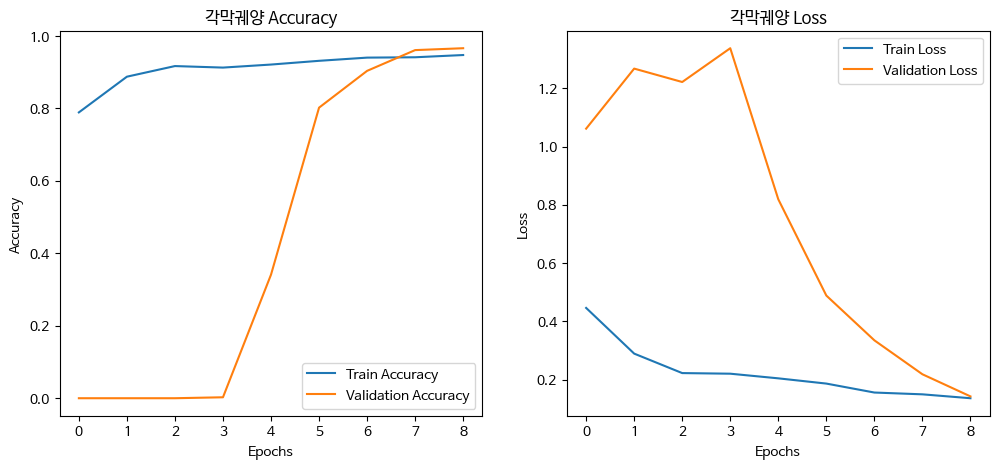

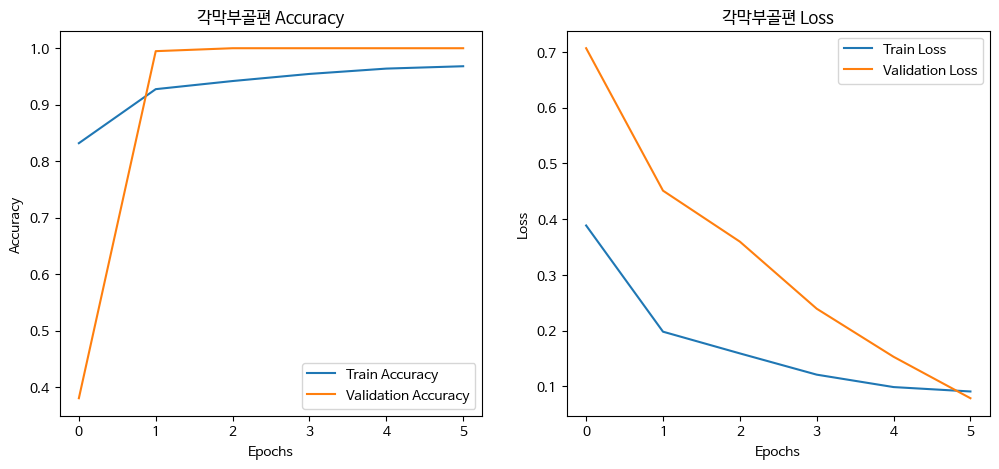

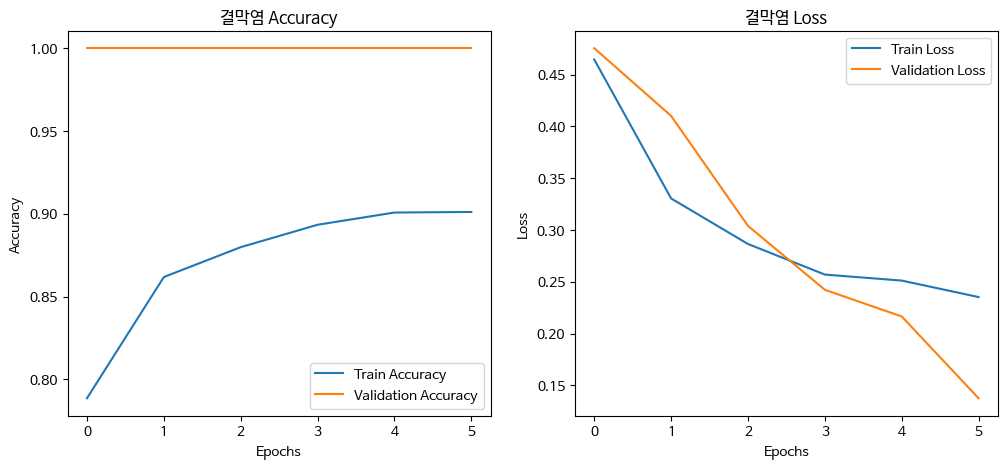

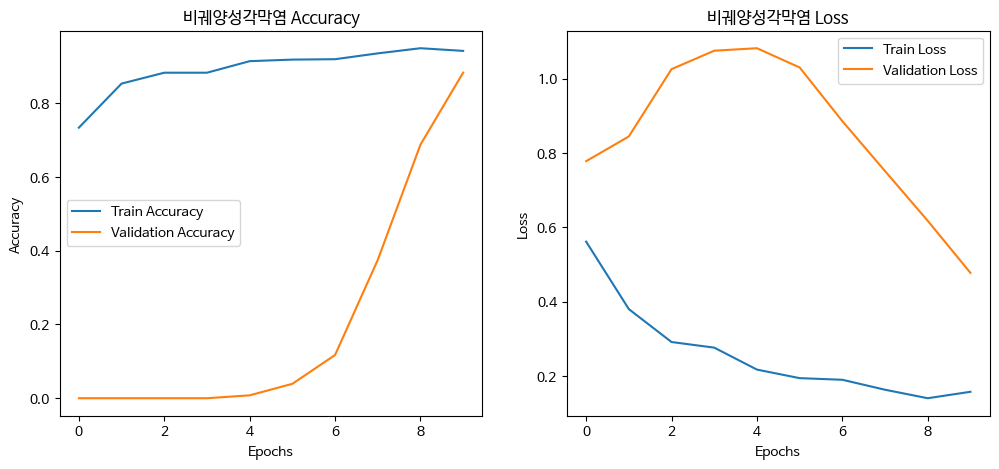

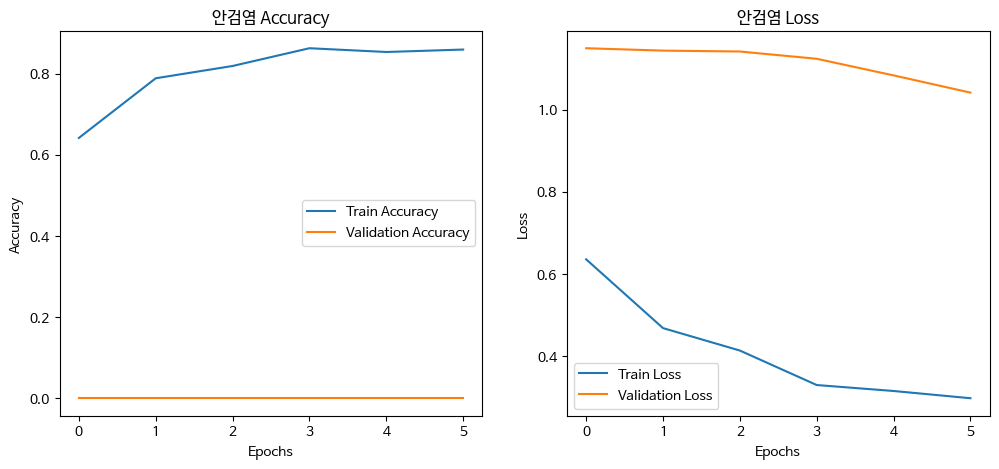

In [6]:
histories = {}
for class_name in models.keys():
    with open(f'history_{class_name}.pkl', 'rb') as f:
        histories[class_name] = pickle.load(f)

# 시각화 함수 정의
def plot_history(history, class_name):
    plt.figure(figsize=(12, 5))
    plt.rc('font', family='NanumBarunGothic')

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{class_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{class_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 각 모델의 학습 기록 시각화
for class_name, history in histories.items():
    plot_history(history, class_name)

In [10]:
# # 각 질병별로 훈련된 모델 로드
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

model_ulcer = load_model('/content/best_model_각막궤양.h5')
model_fseques = load_model('/content/best_model_각막부골편.h5')
model_conjunc = load_model('/content/best_model_결막염.h5')
model_nonulcer = load_model('/content/best_model_비궤양성각막염.h5')
model_bleph = load_model('/content/best_model_안검염.h5')

def load_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # 정규화 (0-1 사이 값)
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    return img_array

# 예시 이미지
image = load_image('/content/drive/MyDrive/종합설계/test_ulcer.jpg')

preds_1 = model_ulcer.predict(image)
preds_2 = model_fseques.predict(image)
preds_3 = model_conjunc.predict(image)
preds_4 = model_nonulcer.predict(image)
preds_5 = model_bleph.predict(image)

# 예측결과 출력
preds_list = [preds_1, preds_2, preds_3, preds_4, preds_5]

diseases = ["각막궤양", "각막부골편", "결막염", "비궤양성각막염", "안검염"]

class_preds = []
probabilities = []

for preds in preds_list:
    class_pred = 1 if preds[0] >= 0.5 else 0
    class_preds.append(class_pred)
    probabilities.append(preds[0])

max_prob_index = probabilities.index(max(probabilities))
max_disease = diseases[max_prob_index]
max_class_pred = class_preds[max_prob_index]

print(f"최대 확률을 가진 질병: {max_disease}, 클래스: {max_class_pred}")

1/1 [==============================] - 1s 864ms/step
최대 확률을 가진 질병: 각막궤양, 클래스: 1


NameError: name 'pred_lists' is not defined

In [11]:
print(preds_list)

[array([[0.79118556]], dtype=float32), array([[0.15434486]], dtype=float32), array([[0.12817447]], dtype=float32), array([[0.6016118]], dtype=float32), array([[0.66309524]], dtype=float32)]


In [8]:
# 모델 생성
# def make_model(input_shpae, num_classes):
#     base_model = ResNet50(weight='imagenet',input_shape=input_shape,include_top=False)
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')()
#     predictions = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)
#     model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# input_shape = (224, 224, 3)
# num_classes = 10

In [9]:
# # 그림 미리보기
# from PIL import Image
# import matplotlib.pyplot as plt

# path = '/content/drive/MyDrive/종합설계/test_bleph.jpg'
# image = Image.open(path)

# # 이미지 표시
# plt.imshow(image)
# plt.axis('off')  # 축 숨기기
# plt.show()